In [12]:
from neural_astar_jax.planner import differentiable_astar
from importlib import reload
import jax.numpy as jnp
import matplotlib.pyplot as plt
reload(differentiable_astar)
from chex import Array
from typing import NamedTuple

from functools import partial
import jax


In [13]:
obstacles_map = jnp.ones((64, 64))
obstacles_map = obstacles_map.at[10:20, 10:20].set(0).at[30:40, 30:40].set(0).at[10:20, 30:40].set(0).at[30:40, 10:20].set(0)
start_map = jnp.zeros((64, 64)).at[1, 1].set(1)
goal_map = jnp.zeros((64, 64)).at[62, 62].set(1)
cost_map = obstacles_map

da = differentiable_astar.DifferentiableAstar(Tmax=1)
%timeit da(cost_map, start_map, goal_map, obstacles_map)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=1/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function body at /home/yonetani/programs/neural-astar-jax/src/neural_astar_jax/planner/differentiable_astar.py:128 for while_loop. This concrete value was not available in Python because it depends on the values of the argument 'carry'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

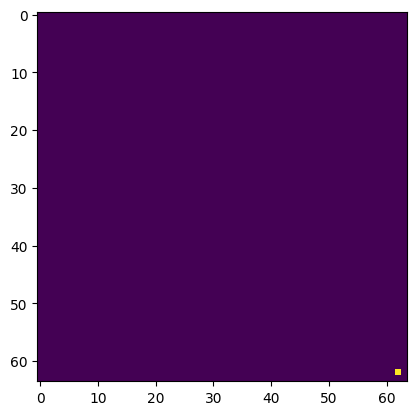

In [11]:
output = da(cost_map, start_map, goal_map, obstacles_map)
plt.imshow(output.path_map)

In [17]:
from neural_astar.planner import VanillaAstar
import torch

va = VanillaAstar()

obstacles_map_t = torch.tensor(obstacles_map.to_py()).unsqueeze(0).unsqueeze(0)
start_map_t = torch.tensor(start_map.to_py()).unsqueeze(0).unsqueeze(0)
goal_map_t = torch.tensor(goal_map.to_py()).unsqueeze(0).unsqueeze(0)
cost_map_t = torch.tensor(cost_map.to_py()).unsqueeze(0).unsqueeze(0)

%timeit va.forward(obstacles_map_t, start_map_t, goal_map_t)

75.2 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%load_ext line_profiler

%lprun -f da.__call__ da(cost_map, start_map, goal_map, obstacles_map)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.120886 s
File: /home/yonetani/programs/neural-astar-jax/src/neural_astar_jax/planner/differentiable_astar.py
Function: __call__ at line 80

Line #      Hits         Time  Per Hit   % Time  Line Contents
    80                                               def __call__(
    81                                                   self, cost_map: Array, start_map: Array, goal_map: Array, obstacles_map: Array
    82                                               ) -> AstarOutput:
    83         1    4282524.0 4282524.0      3.5          carry = self.forward(cost_map, start_map, goal_map, obstacles_map)
    84         1  116576510.0 116576510.0     96.4          path_map = backtrack(goal_map, carry.parents, carry.t)
    85                                           
    86         1      26829.0  26829.0      0.0          return AstarOutput(path_map=path_map, history=carry.history)